<a href="https://colab.research.google.com/github/nishitjain97/Multiclass-Text-Classification-using-Scikit-Learn/blob/master/MCTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [4]:
!wget 'https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv'

--2019-07-03 15:33:08--  https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv
Resolving data.consumerfinance.gov (data.consumerfinance.gov)... 52.206.140.205, 52.206.68.26, 52.206.140.199
Connecting to data.consumerfinance.gov (data.consumerfinance.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [          <=>       ] 724.78M  5.09MB/s    in 91s     

2019-07-03 15:34:43 (7.95 MB/s) - ‘rows.csv’ saved [759989712]



In [2]:
df = pd.read_csv('rows.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/02/2019,Debt collection,Payday loan debt,Took or threatened to take negative or legal a...,Threatened to arrest you or take you to jail i...,NaN,NaN,"Acceptance Solutions Group, INC",TX,775XX,NaN,NaN,Web,07/02/2019,Closed with explanation,Yes,NaN,3293714
1,07/02/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,NaN,Company believes complaint is the result of an...,Source Receivables Management LLC,FL,331XX,NaN,NaN,Web,07/02/2019,Closed with non-monetary relief,Yes,NaN,3293316
2,07/02/2019,"Payday loan, title loan, or personal loan",Installment loan,Struggling to pay your loan,NaN,NaN,NaN,CURO Intermediate Holdings,OH,442XX,NaN,NaN,Web,07/02/2019,Closed with explanation,Yes,NaN,3294303
3,07/02/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,NaN,NaN,"Diversified Consultants, Inc.",TN,385XX,NaN,NaN,Web,07/02/2019,Closed with explanation,Yes,NaN,3294249
4,07/02/2019,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,Terrill Outsourcing Group,SC,297XX,NaN,NaN,Web,07/02/2019,Closed with explanation,Yes,NaN,3293560


In [3]:
df.shape

(1323912, 18)

In [0]:
from io import StringIO

In [5]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]

df.columns = ['Product', 'Consumer_complaint_narrative']

df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
39185,"Credit reporting, credit repair services, or o...","AFTER REVIEWING MY CREDIT REPORT, I HAVE IDENT...",0
39265,"Credit reporting, credit repair services, or o...","AFTER REVIEWING MY CREDIT REPORT, I HAVE IDENT...",0
39707,"Credit reporting, credit repair services, or o...","AFTER REVIEWING MY CREDIT REPORT, I HAVE IDENT...",0
41416,"Credit reporting, credit repair services, or o...",This people are rude below is the paperwork of...,0
44715,"Credit reporting, credit repair services, or o...",I have been a victim of identity theft,0


In [11]:
df.shape

(393434, 3)

In [0]:
df = df[:5000]

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

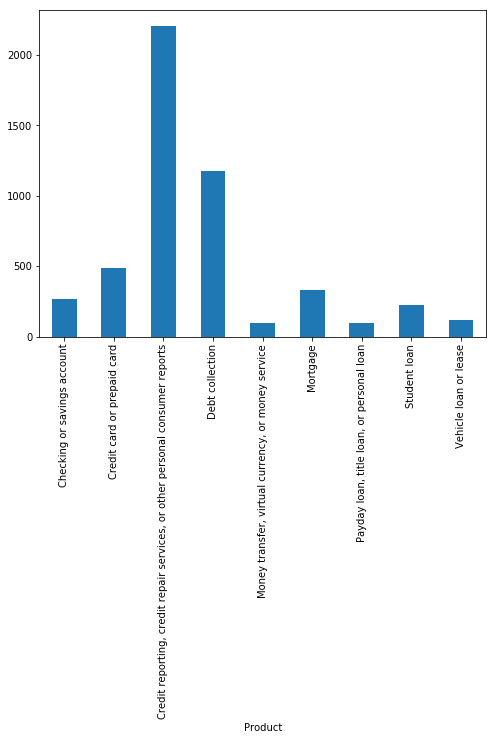

In [14]:
fig = plt.figure(figsize=(8, 6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(5000, 12934)

In [0]:
from sklearn.feature_selection import chi2
import numpy as np

In [18]:
N = 2

for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print(" . Most correlated unigrams:\n. {}".format('\n.'.join(unigrams[-N:])))
    print(" . Most correlated bigrams:\n. {}".format('\n.'.join(bigrams[-N:])))

# 'Bank account or service':
 . Most correlated unigrams:
. extent
.disputed
 . Most correlated bigrams:
. dispute process
.zip code
# 'Checking or savings account':
 . Most correlated unigrams:
. branch
.overdraft
 . Most correlated bigrams:
. overdraft fees
.checking account
# 'Consumer Loan':
 . Most correlated unigrams:
. extent
.disputed
 . Most correlated bigrams:
. dispute process
.zip code
# 'Credit card':
 . Most correlated unigrams:
. extent
.disputed
 . Most correlated bigrams:
. dispute process
.zip code
# 'Credit card or prepaid card':
 . Most correlated unigrams:
. express
.card
 . Most correlated bigrams:
. american express
.credit card
# 'Credit reporting':
 . Most correlated unigrams:
. extent
.disputed
 . Most correlated bigrams:
. dispute process
.zip code
# 'Credit reporting, credit repair services, or other personal consumer reports':
 . Most correlated unigrams:
. report
.transunion
 . Most correlated bigrams:
. xxxx transunion
.credit report
# 'Debt collection':


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [0]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [22]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [0]:
from sklearn.model_selection import cross_val_score

In [26]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

In [0]:
import seaborn as sns

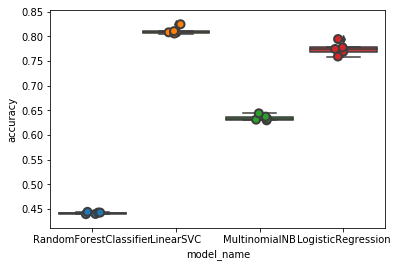

In [29]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()